In [1]:
import pyodbc
import sys
import datetime

from Activo import *
from Accion import *
from Bono import *
from Derivado import *
from DerivadosTipos.DerivadosSCC import *
from DerivadosTipos.DerivadosFWD import *

from extraer_accion import *


from Cartera import *

In [2]:
server = '172.16.1.38'
username = 'sa'
password = 'qwerty123'
driver = '{ODBC Driver 17 for SQL Server}'
cn = pyodbc.connect('DRIVER=' + driver + ';SERVER=' + server + ';UID=' + username + ';PWD=' + password)

In [3]:
def cambiar_fecha(fecha):

    fechas = fecha.split("-")
    fechas = fechas[2].split(" ")[0] + "/" + fechas[1] + "/" + fechas[0]
    return fechas

In [4]:
def bonos_dbAlgebra(n,cn):
    bonos = 'SELECT TOP(' + str(n) + ") bono.Moneda, bono.TablaDesarrollo, bono.Base1 , bono.Base2, bono.FechaEmision, riesgo.Riesgo AS RiesgoInt FROM [dbAlgebra].[dbo].[TdNemoRF] AS bono , [dbAlgebra].[dbo].[VwRiesgoRF] AS riesgo WHERE bono.Nemotecnico = riesgo.Nemotecnico"
    bonos = pd.read_sql(bonos, cn)
    return pd.DataFrame(bonos)

def derivados_dBDerivados(cantidad, cn):

    derivados = "SELECT TOP ("+ str(cantidad) +") * FROM [dbDerivados].[dbo].[TdCarteraDerivados_V2] WHERE Tipo = 'SCC'"
    derivados = pd.read_sql(derivados, cn)

    derivado = pd.DataFrame()
    dev = []

    for i in range(cantidad):

        info_derivado = dict()
        info_derivado["Tipo"] = derivados["Tipo"][i]
        info_derivado["ID_Key"] = derivados["ID_Key"][i]
        info_derivado["Administradora"] = derivados["Administradora"][i]
        info_derivado["Fondo"] = derivados["Fondo"][i]
        info_derivado["Contraparte"] = derivados["Contraparte"][i]
        info_derivado["ID"] = int(derivados["ID"][i])
        info_derivado["Nemotecnico"] = derivados["Nemotecnico"][i]
        info_derivado["Mercado"] = derivados["Mercado"][i]     
        fecha = datetime.date(2017, 12, 20)
        hora = '1700'
        info_derivado["FechaEfectiva"] = cambiar_fecha(str(derivados["FechaEfectiva"][i]))
        info_derivado["FechaVenc"] = cambiar_fecha(str(derivados["FechaVenc"][i]))
        info_derivado["AjusteFeriados"] = derivados["AjusteFeriados"][i]
        info_derivado["NocionalActivo"] = derivados["NocionalActivo"][i]
        info_derivado["NocionalPasivo"] = derivados["NocionalActivo"][i]

        info_derivado["MonedaActivo"] = derivados["MonedaActivo"][i]
        info_derivado["MonedaPasivo"] = derivados["MonedaPasivo"][i]

        info_derivado["MonedaBase"] = derivados["MonedaBase"][i]
        info_derivado["TipoTasaActivo"] = derivados["TipoTasaActivo"][i]
        info_derivado["TipoTasaPasivo"] = derivados["TipoTasaPasivo"][i]
        info_derivado["TasaActivo"] = derivados["TasaActivo"][i]
        info_derivado["TasaPasivo"] = derivados["TasaPasivo"][i]
        info_derivado["FrecuenciaActivo"] = derivados["FrecuenciaActivo"][i]
        info_derivado["FrecuenciaPasivo"] = info_derivado["FrecuenciaActivo"]

        info1 = pd.DataFrame([info_derivado])
        derivado_info = DerivadosSCC(fecha, hora, info1, cn)

        dev.append(derivado_info)

    derivado["Derivado"] = dev
    return derivado

In [5]:
def conversionSYP(riesgo):
    return {1: 'AAA',2: 'AA',3: 'AA',4: 'AA',5: 'A',6: 'A',7: 'A',8: 'BBB',9: 'BBB',10: 'BBB',\
            11: 'BB',12: 'BB',13: 'BB',14: 'B',15: 'B',16: 'B',17: 'CCC',18: 'CC',19: 'CC',20: 'C',\
            21: 'C',22: 'C',23: 'D',24: 'E'}.get(riesgo)

def ajustes(bonos):
    bonos['FechaEmision'] = bonos['FechaEmision'].apply(lambda x: x.strftime('%Y-%m-%d'))
    bonos['Base1'] = bonos['Base1'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Base2'] = bonos['Base2'].apply(lambda x: x if x != -1 else 'ACT')
    bonos['Convencion'] = bonos['Base1'].apply(lambda x: str(x)) + '/' + bonos['Base2'].apply(lambda x: str(x))
    bonos['Riesgo'] = bonos['RiesgoInt'].apply(lambda x: conversionSYP(x))
    return bonos

In [6]:
#bonos = ajustes(bonos_dbAlgebra(1,cn))
#bonos

In [7]:
derivados = derivados_dBDerivados(2, cn)
derivados["Derivado"][1].genera_flujos()
derivados["Derivado"][1].valoriza_flujos()
derivados["Derivado"][1].flujos_valorizados[["ID","ActivoPasivo", "Fecha", "FechaFixing", "FechaFlujo", "FechaPago", "Flujo", "ValorPresenteMonFlujo", "Moneda", "MonedaBase"]]

C:\Users\Lenovo\Documents\Universidad\Practica\Cartera_V2\Practica\Intento\Cartera\DerivadosTipos\DerivadosSCC.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_cartera.MonedaActivo[0] = "CLP"


,ID,ActivoPasivo,Fecha,FechaFixing,FechaFlujo,FechaPago,Flujo,ValorPresenteMonFlujo,Moneda,MonedaBase
0,1367,-1,2017-12-20,2020-05-12,2020-05-12,2020-05-12,7.445063e+08,6.929181e+08,CLP,CLP
1,1367,-1,2017-12-20,2020-11-12,2020-11-12,2020-11-12,1.959144e+08,1.788355e+08,CLP,CLP
2,1367,-1,2017-12-20,2021-05-12,2021-05-12,2021-05-12,2.066496e+08,1.848157e+08,CLP,CLP
3,1367,-1,2017-12-20,2021-11-12,2021-11-12,2021-11-12,1.021427e+10,8.943431e+09,CLP,CLP
4,1367,1,2017-12-20,2020-05-12,2020-05-12,2020-05-12,7.304466e+07,6.798326e+07,CLP,CLP
5,1367,1,2017-12-20,2020-11-12,2020-11-12,2020-11-12,7.385030e+07,6.741237e+07,CLP,CLP
6,1367,1,2017-12-20,2021-05-12,2021-05-12,2021-05-12,7.264186e+07,6.496674e+07,CLP,CLP
7,1367,1,2017-12-20,2021-11-12,2021-11-12,2021-11-12,1.007385e+10,8.820480e+09,CLP,CLP


In [8]:
# acciones = historico("DE000DWS2D90", "A", 60)


16
   Fechas  Frecuencia
0     466           4
1     650           4
2     831           4
3    1015           4
Hola
1     466.0
0     740.5
2    1015.0
Name: 0, dtype: float64


ZeroDivisionError: division by zero

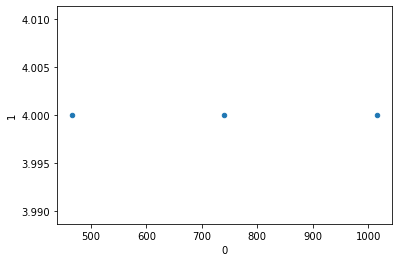

In [9]:
cartera = Cartera(pd.DataFrame(), pd.DataFrame(), derivados,'CLP', datetime.date(2019,2,1), cn, 60)

In [ ]:
print(cartera.get_historicos_totales())

In [ ]:
print(cartera.get_retornos_totales())

In [ ]:
cartera.set_volatilidad_cartera()
print(cartera.get_volatilidad_cartera())